# CNN보다 더 성능이 우수한 모델들 실습
## 1. LeNet-5
* 입력 이미지 --> Conv1 --> tanh --> Pool1 --> Conv2 --> tanh --> Pool2 --> Conv3 --> tanh --> fc1 --> softmax

In [ ]:
from keras.layers.pooling import GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 
import numpy as np 
import keras
import math
import keras.backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.datasets import mnist
from keras.datasets import cifar10
from tensorflow.keras.layers import Layer


(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(len(X_train),'\n', len(X_test))

60000 
 10000


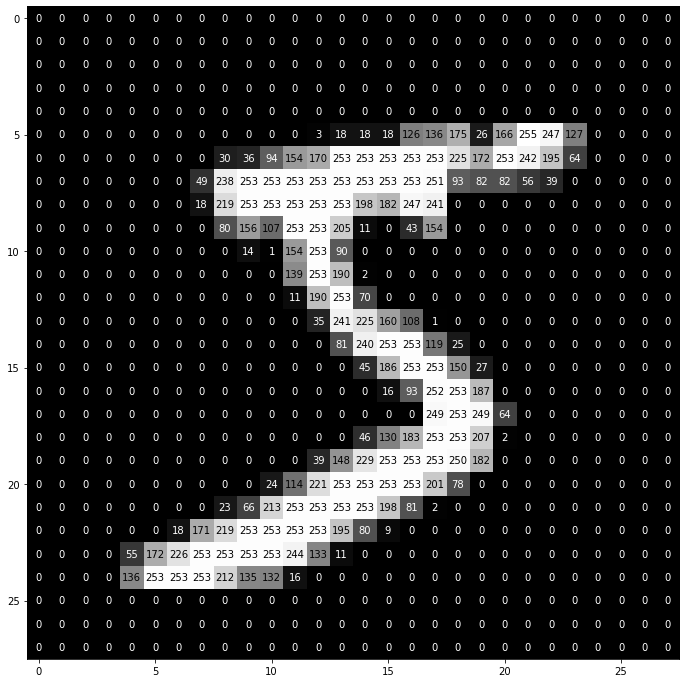

In [ ]:
# 이미지의 세부 색상 및 픽셀값 확인
# (0에 가까울수록 검은색, 1에 가까울수록 흰색)

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

In [ ]:
# 전처리
# 1) 픽셀값 정규화 및 라벨에 대한 One-Hot Encoding

mean = np.mean(X_train)
std = np.std(X_train)
num_classes = 10

X_train = (X_train-mean) / (std + 1e-7)
X_test = (X_test-mean) / (std + 1e-7)

print('Integer labeled values : ', y_train[:10])
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape[0])
print('One-Hot Encoding된 라벨값: ', y_train[:10])

Integer labeled values :  [5 0 4 1 9 2 1 3 1 4]
(60000, 28, 28)
60000
10000
One-Hot Encoding된 라벨값:  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
# 2) 모든 픽셀값을 28X28로 맞춤
img_rows, img_columns = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_columns, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_columns, 1)
input_shape = (img_rows, img_columns, 1)

print(X_train.shape)
print(input_shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [ ]:
kargs = {'model_name' : 'LeNet_5', 
         'num_filters_1' : 6, 'num_filters_2' : 16, 'num_filters_3' : 120,
         'kernel_size' : 5, 'pool_size' : 2, 'strides'     : 1,
         'Dense_1' : 84, 'Dense_2' : 10
         }


class LeNet_5(tf.keras.Model):
  def __init__(self, **kargs):
    super(LeNet_5, self).__init__(name=kargs['model_name']) 

    self.conv_1 = Conv2D(kargs['num_filters_1'], kernel_size=kargs['kernel_size'], 
                         strides=kargs['strides'], activation='tanh', input_shape=input_shape, 
                         padding='same', name='conv2d_1')
    self.conv_2 = Conv2D(kargs['num_filters_2'], kernel_size=kargs['kernel_size'],
                         strides=kargs['strides'], activation='tanh', padding='valid', name='conv2d_2')
    self.conv_3 = Conv2D(kargs['num_filters_3'], kernel_size=kargs['kernel_size'],
                         strides=kargs['strides'], activation='tanh', padding='valid', name='conv2d_3')

    self.pool = AveragePooling2D(pool_size=kargs['pool_size'], strides=2, padding='valid', name='avgpool_2d')

    self.flatten = Flatten(name='flatten')

    self.fc_1 = Dense(kargs['Dense_1'], activation='tanh', name='fc_layer_1')
    self.fc_2 = Dense(kargs['Dense_2'], activation='softmax', name='fc_layer_2')

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.pool(x)
    x = self.conv_2(x)
    x = self.pool(x)
    x = self.conv_3(x)
    x = self.flatten(x)
    x = self.fc_1(x)
    return self.fc_2(x)

model = LeNet_5(**kargs)
model.build(input_shape=(32, 28, 28, 1))
print(model.summary())

# LearningRateScheduler : 미리 설정된 일정에 맞춰 학습률을 감퇴시키는 Callback 옵션
# lr_schedule : epoch이 진행될 수록 학습속도가 느려지는 함수
def lr_schedule(epoch):
  if epoch <= 2:
    lr = 5e-4  # 0.0005
  
  elif epoch > 2 and epoch <= 5:
    lr = 2e-4  # 0.0002
  
  elif epoch > 5 and epoch <= 9:
    lr = 5e-5  # 0.00005
  
  else:
    lr = 1e-5  # 0.00001
  
  return lr

Model: "LeNet_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           multiple                  156       
                                                                 
 conv2d_2 (Conv2D)           multiple                  2416      
                                                                 
 conv2d_3 (Conv2D)           multiple                  48120     
                                                                 
 avgpool_2d (AveragePooling2  multiple                 0         
 D)                                                              
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 fc_layer_1 (Dense)          multiple                  10164     
                                                           

In [ ]:
X_train = tf.image.convert_image_dtype(X_train, tf.float32)
X_test = tf.image.convert_image_dtype(X_test, tf.float32)

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
cp = ModelCheckpoint('LeNet_5.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=5, monitor='val_acc', verbose=0, min_delta=0.0001, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test),
          callbacks=[cp,es,lr_scheduler], shuffle=True)

Epoch 1/20
1866/1875 [============================>.] - ETA: 0s - loss: 1.8025 - acc: 0.5853
Epoch 1: val_acc improved from -inf to 0.74030, saving model to LeNet_5.h5
1875/1875 [==============================] - 19s 4ms/step - loss: 1.7999 - acc: 0.5860 - val_loss: 1.2459 - val_acc: 0.7403 - lr: 5.0000e-04
Epoch 2/20
1867/1875 [============================>.] - ETA: 0s - loss: 0.9856 - acc: 0.7782
Epoch 2: val_acc improved from 0.74030 to 0.81450, saving model to LeNet_5.h5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9849 - acc: 0.7783 - val_loss: 0.7868 - val_acc: 0.8145 - lr: 5.0000e-04
Epoch 3/20
1872/1875 [============================>.] - ETA: 0s - loss: 0.7124 - acc: 0.8250
Epoch 3: val_acc improved from 0.81450 to 0.84570, saving model to LeNet_5.h5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7123 - acc: 0.8249 - val_loss: 0.6233 - val_acc: 0.8457 - lr: 5.0000e-04
Epoch 4/20
1875/1875 [==============================] - ETA: 0s - los

In [ ]:
model.load_weights('LeNet_5.h5')
score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(score[1])

0.8730999827384949


## 2. AlexNet
* 입력이미지 --> Conv1 --> Pool1 --> Conv2 --> Pool2 --> Conv3 --> Conv4 --> Conv5 --> Pool3 --> FC1 --> FC2 --> Softmax

## 3. VGGNet(=VGG16)
* 쌓는 층 수에 따라 VGG16 또는 VGG19...등으로 불림
* 패딩 및 스트라이드가 1인 합성곱 신경망을 여러 층 겹겹이 쌓음
* 필터 크기가 작은 합성곱 신경망을 여러층 겹겹이 쌓음

In [ ]:
# 출력 결과 파라미터 수가 1.38억개 정도에 해당한다!
# 실험을 위해서는 224*224보다 높은 해상도를 가진 사진들을 가져오자!


kargs_2 = {'model_name' : 'VGG-16',
           'num_filter_1' : 64, 'num_filter_2' : 128, 
           'num_filter_3' : 256, 'num_filter_4' : 512,
           'kernel_size' : 3, 'strides_1' : 1, 'strides_2' : 2,
           'pool_size' : 2, 'dropout_rate' : 0.5}


class vgg16(tf.keras.Model):

  def __init__(self, **kargs_2):
    super(vgg16, self).__init__(name=kargs_2['model_name'])

    self.conv_1 = Conv2D(kargs_2['num_filter_1'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', input_shape=(224,224,3), padding='same', name='conv_1')
    self.conv_2 = Conv2D(kargs_2['num_filter_1'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_2')
    self.conv_3 = Conv2D(kargs_2['num_filter_2'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_3')
    self.conv_4 = Conv2D(kargs_2['num_filter_2'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_4')
    self.conv_5 = Conv2D(kargs_2['num_filter_3'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_5')
    self.conv_6 = Conv2D(kargs_2['num_filter_3'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_6')
    self.conv_7 = Conv2D(kargs_2['num_filter_3'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_7')
    self.conv_8 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_8')
    self.conv_9 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_9')
    self.conv_10 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_10')
    self.conv_11 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_11')
    self.conv_12 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_12')
    self.conv_13 = Conv2D(kargs_2['num_filter_4'], kernel_size=kargs_2['kernel_size'], strides=kargs_2['strides_1'],
                         activation='relu', padding='same', name='conv_13')
    
    self.pool = MaxPooling2D(pool_size=kargs_2['pool_size'], strides=kargs_2['strides_2'])
    self.flatten = Flatten()
    self.dropout = Dropout(kargs_2['dropout_rate'])
    self.fc_1 = Dense(4096, activation='relu')
    self.fc_2 = Dense(4096, activation='relu')
    self.fc_3 = Dense(10, activation='softmax')


  def call(self, inputs):
    
    # first_block
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.pool(x)
    
    # second block
    x = self.conv_3(x)
    x = self.conv_4(x)
    x = self.pool(x)

    # third block
    x = self.conv_5(x)
    x = self.conv_6(x)
    x = self.conv_7(x)
    x = self.pool(x)

    # fourth block
    x = self.conv_8(x)
    x = self.conv_9(x)
    x = self.conv_10(x)
    x = self.pool(x)

    # fifth block
    x = self.conv_11(x)
    x = self.conv_12(x)
    x = self.conv_13(x)
    x = self.pool(x)

    # sixth block(fc_layer)
    x = self.flatten(x)
    x = self.fc_1(x)
    x = self.dropout(x)
    x = self.fc_2(x)
    x = self.dropout(x)
    return self.fc_3(x)

model_2 = vgg16(**kargs_2)
model_2.build(input_shape=(1,224,224,3))
print(model_2.summary())



Model: "VGG-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             multiple                  1792      
                                                                 
 conv_2 (Conv2D)             multiple                  36928     
                                                                 
 conv_3 (Conv2D)             multiple                  73856     
                                                                 
 conv_4 (Conv2D)             multiple                  147584    
                                                                 
 conv_5 (Conv2D)             multiple                  295168    
                                                                 
 conv_6 (Conv2D)             multiple                  590080    
                                                                 
 conv_7 (Conv2D)             multiple                  59008

## 4. GoogLeNet : 인셉션 모듈을 활용한 이미지 분석

* 인셉션 모듈 : 단순 표현 / 차원축소를 적용한 인셉션
* B 부분에 인셉션 모듈을 삽입하여 이미지 분류의 성능을 높임
* A부분 / B부분 / C부분
* A부분 : AlexNet과 비슷한 합성곱 & 정규화 & 풀링층 등이 들어감
* B부분 : 인셉션 모듈 9개를 삽입
* C부분 : 분류기

In [ ]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid = load_cifar10_data(224, 224)

In [ ]:
# 인셉션 모듈 : 차원축소를 추가
# 1x1 합성곱층 --> 1x1 합성곱층(차원축소) + 3x3 합성곱층 --> 1x1 합성곱층(차원축소) + 5x5 합성곱층 
# --> 3x3 풀링층 + 1x1 합성곱층(차원축소)

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5,
                     filters_pool_proj, name=None):
  
  conv_1x1 = Conv2D(filters_1x1, kernel_size=(1,1), padding='same', activation='relu',
                    kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  
  # 3x3 합성곱층 경로 --> 1x1 Conv(차원축소) + 3x3 Conv
  pre_conv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1,1), padding='same', activation='relu',
                    kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

  conv_3x3 = Conv2D(filters_3x3, kernel_size=(3,3), padding='same', activation='relu',
                    kernel_initializer=kernel_init, bias_initializer=bias_init)(pre_conv_3x3)
  
  # 5x5 합성곱층 경로 --> 1x1 Conv(차원축소) + 5x5 Conv
  pre_conv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1,1), padding='same', activation='relu',
                        kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

  conv_5x5 = Conv2D(filters_5x5, kernel_size=(5,5), padding='same', activation='relu',
                    kernel_initializer=kernel_init, bias_initializer=bias_init)(pre_conv_5x5)
  
  # 풀링층 경로 --> 풀링층(pool_size=3) + 1x1 Conv(차원축소)
  pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1,1), padding='same', activation='relu',
                     kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
  
  # output --> 세 필터를 깊이 방향으로 다시 연접 --> 원래의 깊이를 되찾음
  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
  return output
  

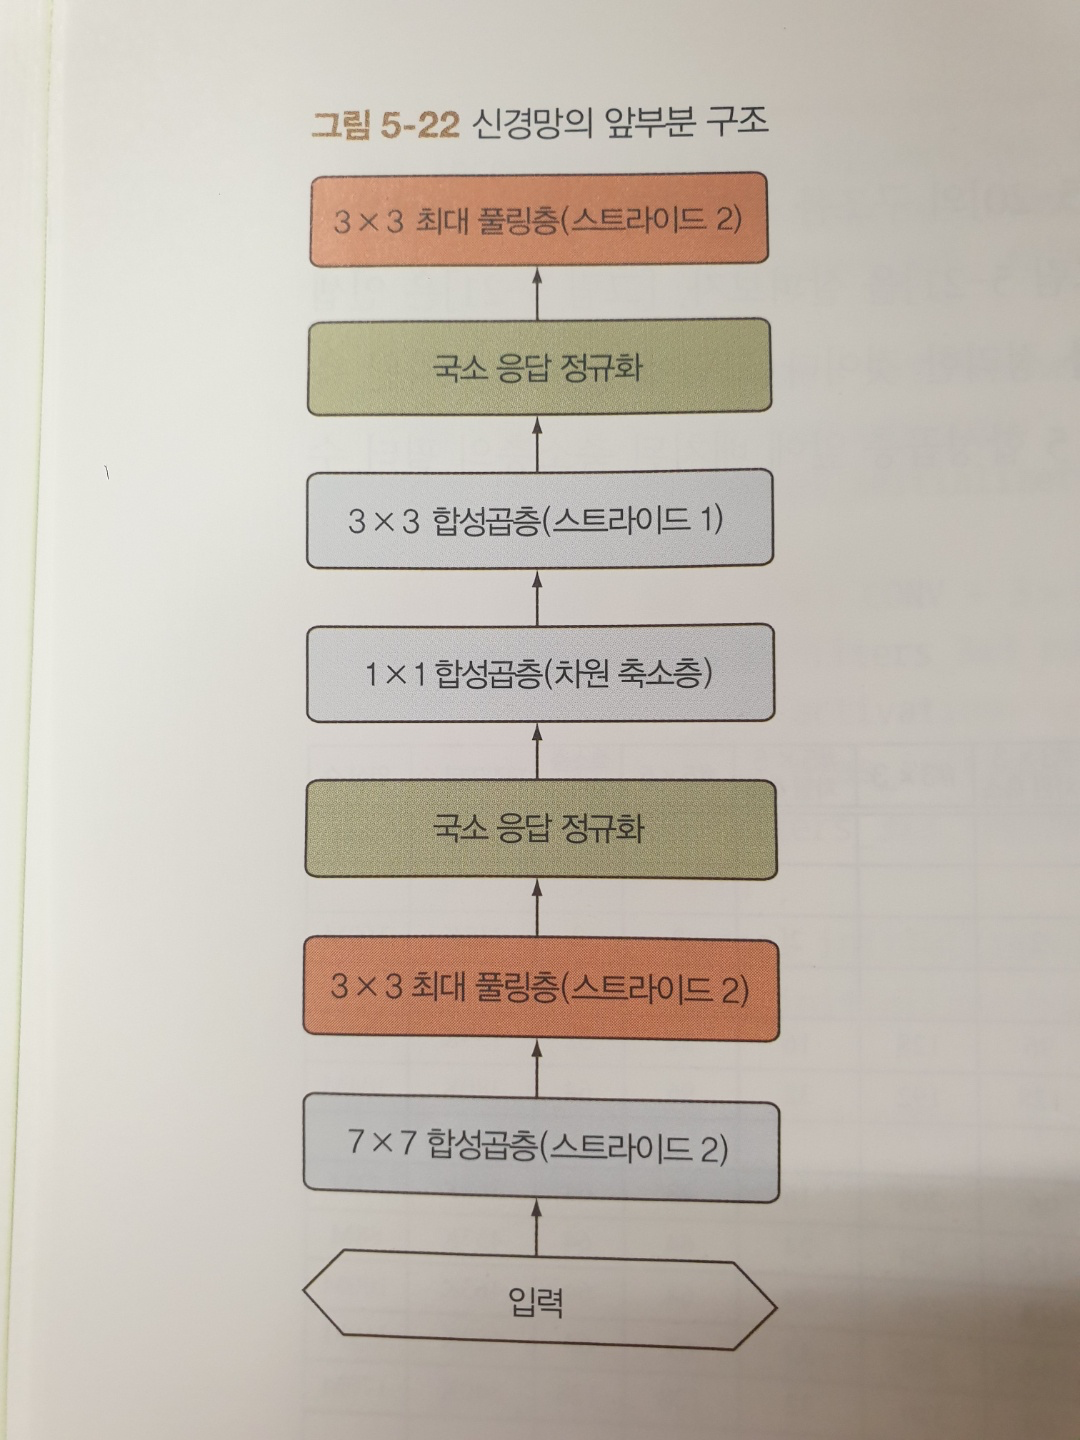

In [ ]:
# A 부분 구현

input_layer = Input(shape=(224,224,3))

# 국소 응답 정규화층 중간에 삽입
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

x = Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu', name='conv_1_7x7/2',
           kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)

x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)

# 차원축소층
x = Conv2D(64, (1,1), padding='same', strides=(1,1), activation='relu', name='conv_2a_3x3/1')(x)

x = Conv2D(192, (3,3), padding='same', strides=(1,1), activation='relu', name='conv_2b_3x3/1')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_2_3x3/2')(x)

In [ ]:
# B부분 구현 : 9개의 인셉션 모듈
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                     filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32,
                     name='inception_3a')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                     filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64,
                     name='inception_3b')
x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_3_3x3/2')(x)


x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                     filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64,
                     name='inception_4a')
x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224,
                     filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64,
                     name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256,
                     filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64,
                     name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288,
                     filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128,
                     name='inception_4d')
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320,
                     filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128,
                     name='inception_4e')
x = MaxPooling2D((3,3), padding='same', strides=(2,2), name='max_pool_4_3x3/2')(x)


x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320,
                     filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128,
                     name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384,
                     filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128,
                     name='inception_5b')

In [ ]:
# C부분 구현
x = AveragePooling2D((7,7), strides=1, padding='valid')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax', name='output')(x)

In [ ]:
model_3 = Model(input_layer, [x], name='googlenet')
print(model_3.summary())

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                        

## 5. ResNet

In [ ]:
from keras.applications.resnet import ResNet50

base_model = ResNet50(weights= None, include_top=True, input_shape= (224, 224, 3), classes=10)
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           